In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import scipy
from scipy.signal import savgol_filter
import pickle as pkl
from util import config

import analysis
import data_preprocess
import nn
import plot

In [4]:
# Read the preprocessed dataset 
with open('./data/data_stand.pkl','rb') as f:  
    data=pkl.load(f)
with open('./data/data_non_stand.pkl','rb') as f:  
    data_non_stand=pkl.load(f)

In [5]:
years_str=config['experiments']['years']
region_name =config['experiments']['region']
travel_mode = config['experiments']['mode']
fixed_effect = config['experiments']['variables']

In [6]:
# split the data by years
data2005=data[data.Year==2005].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2006=data[data.Year==2006].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2007=data[data.Year==2007].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2008=data[data.Year==2008].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2009=data[data.Year==2009].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2010=data[data.Year==2010].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2011=data[data.Year==2011].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2012=data[data.Year==2012].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2013=data[data.Year==2013].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2014=data[data.Year==2014].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2015=data[data.Year==2015].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2016=data[data.Year==2016].sort_values(by=['Mode','Household_region']).reset_index(drop=True)

data_list=[data2005,data2006,data2007,data2008,data2009,data2010,data2011,data2012,data2013,data2014,data2015,data2016]

# Original codes for MNL in my dissertation

In [8]:
corr_choice_attribute=pd.DataFrame(columns=plot.get_modes(),index=nn.get_vars())

In [9]:
# choose vars of each mode
data_test_mnl=data.sample(100000,random_state=42).reset_index()
data_test_mnl.drop(columns=['index','IndividualID','HouseholdID','Year','Household_region'],inplace=True)
mnl_col,corr_mnl=nn.get_vars_MNL(data_test_mnl)

Columns correlated with the alternatives Walk:
Mode_y                 1.000000
Household_car          0.128122
Trip_distance          0.119677
Household_licence      0.104553
Trip_purpose_1         0.073007
Trip_purpose_6         0.060728
Trip_purpose_2         0.054624
Household_employeed    0.049424
Individual_income      0.048711
Trip_purpose_3         0.044048
Name: Mode_y, dtype: float64
Columns selected in the utility function of Walk:
['Household_car', 'Trip_distance', 'Household_licence', 'Trip_time']
 
Columns correlated with the alternatives Bicycle:
Mode_y                    1.000000
Household_bike            0.077892
Trip_purpose_1            0.069661
Individual_gender_1       0.063832
Household_car             0.059819
Trip_distance             0.039636
Individual_age            0.029392
Household_licence         0.028681
Trip_purpose_4            0.027300
Individual_education_1    0.023555
Name: Mode_y, dtype: float64
Columns selected in the utility function of Bicycle:
[

In [10]:
accuracy_mnl=[]
prob_mnl_pre=[]
for i in data_list:
    acc,pred=nn.MNL_MODEL(i,mnl_col)
    accuracy_mnl.append(acc)
    prob_mnl_pre.append(pred)
    
pd.DataFrame(accuracy_mnl).to_csv('accuracy_mnl.csv')
for i in range(len(years_str)):
    pd.DataFrame(prob_mnl_pre[i]).to_csv(f'prob_mnl_pre{years_str[i]}.csv')

In [54]:
accuracy_mnl=pd.read_csv('accuracy_mnl.csv')

# Biogeme Package

Reference:https://github.com/mncosta/biogeme_tutorial/blob/ad508a367b6cad0a4dca294c98bda97899c54b22/6.1-MultinomialLogitAndProbitModels/.ipynb_checkpoints/04-logit-train-test-checkpoint.ipynb

In [7]:
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.expressions as exp
import seaborn as sns
import biogeme.optimization as opt
import matplotlib.pyplot as plt
import biogeme.results as res
from biogeme.expressions import Beta, DefineVariable

ImportError: /home/yutong/anaconda3/envs/rebnn/lib/python3.6/site-packages/biogeme/cbiogeme.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZTVN10__cxxabiv120__si_class_type_infoE

In [27]:
data2016['AV']=1
database2016 = db.Database("data_base2016", data2016)

In [28]:
globals().update(database2016.variables)

In [29]:
train_index,test_index=nn.train_test_index(data2016)
data2016_train=data2016.loc[train_index]
data2016_test=data2016.loc[test_index]

In [30]:
database2016_train=db.Database("database2016_train", data2016_train)
database2016_test=db.Database("database2016_test", data2016_test)

In [31]:
A_walk   = exp.Beta('A_walk',0,None ,None ,0)
B_walk_cars   = exp.Beta('B_walk_cars',0,None ,None ,0)
B_walk_distance = exp.Beta('B_walk_distance',0,None ,None ,0)
B_walk_licence  = exp.Beta('B_walk_licence',0,None ,None ,0)
B_wlak_time   = exp.Beta('B_wlak_time',0,None ,None ,0)

A_bike   = exp.Beta('A_bike ',0,None ,None ,1)
B_bike_bikes   = exp.Beta('B_bike_bikes',0,None ,None ,0)
B_bike_purpose1 = exp.Beta('B_bike_purpose1',0,None ,None ,0)
B_bike_time   = exp.Beta('B_bike_time ',0,None ,None ,0)

A_car  = exp.Beta('A_car',0,None ,None ,0)
B_car_cars   = exp.Beta('B_car_cars',0,None ,None ,0)
B_car_pop= exp.Beta('B_car_pop',0,None ,None ,0)
B_car_licence   = exp.Beta('B_car_licence',0,None ,None ,0)
B_car_time   = exp.Beta('B_car_time',0,None ,None ,0)
B_car_age= exp.Beta('B_car_age',0,None ,None ,0)
B_car_set1   = exp.Beta('B_car_set1',0,None ,None ,0)

A_bus  = exp.Beta('A_bus',0,None ,None ,0)
B_bus_cars   = exp.Beta('B_bus_cars',0,None ,None ,0)
B_bus_licence= exp.Beta('B_bus_licence',0,None ,None ,0)
B_bus_pop   = exp.Beta('B_bus_pop',0,None ,None ,0)
B_bus_time   = exp.Beta('B_bus_time',0,None ,None ,0)

A_rail= exp.Beta('A_rail',0,None ,None ,0)
B_rail_pop   = exp.Beta('B_rail_pop',0,None ,None ,0)
B_rail_time= exp.Beta('B_rail_time',0,None ,None ,0)
B_rail_distance  = exp.Beta('B_rail_distance',0,None ,None ,0)
B_rail_purpose1   = exp.Beta('B_rail_purpose1',0,None ,None ,0)
B_rail_edu1= exp.Beta('B_rail_edu1',0,None ,None ,0)

In [32]:
Walk= A_walk + \
    B_walk_cars * Household_car + \
    B_walk_distance * Trip_distance + \
    B_walk_licence * Household_licence + \
    B_wlak_time * Trip_time
    
Bike=A_bike+\
    B_bike_bikes * Household_bike + \
    B_bike_purpose1 * Trip_purpose_1 + \
    B_bike_time * Trip_time
    
Car=A_car+\
    B_car_cars * Household_car + \
    B_car_pop * Population_density + \
    B_car_licence * Household_licence + \
    B_car_time * Trip_time+\
    B_car_age * Individual_age + \
    B_car_set1 * Household_settlement_1

Bus=A_bus+\
    B_bus_cars * Household_car+\
    B_bus_licence * Household_licence+\
    B_bus_pop * Population_density+\
    B_bus_time * Trip_time

Rail=A_rail+\
    B_rail_pop * Population_density+\
    B_rail_time * Trip_time +\
    B_rail_distance * Trip_distance +\
    B_rail_purpose1 * Trip_purpose_1 +\
    B_rail_edu1 * Individual_education_1

In [33]:
V = {1: Walk,
     2: Bike,
     3: Car,
     4:Bus,
     5:Rail}

av = {1: AV,
      2: AV,
      3: AV,
      4:AV,
      5:AV
    }

In [34]:
# Define the model
logprob = models.loglogit(V,av, Mode)

#Define the Biogeme object
biogeme  = bio.BIOGEME(database2016_train, logprob)

biogeme.modelName = "data2016_train"

In [35]:
biogeme.generateHtml = True
biogeme.generatePickle = True

results = biogeme.estimate()

print(f"HTML file:    {results.data.htmlFileName}")
print(f"Pickle file:  {results.data.pickleFileName }")

HTML file:    data2016_train~04.html
Pickle file:  data2016_train~04.pickle


In [36]:
betas= results.getBetaValues()
for k,v in betas.items():
    print(f"{k:10}=\t{v:.3g}")

A_bus     =	0.852
A_car     =	4.32
A_rail    =	-0.0364
A_walk    =	-2.9
B_bike_bikes=	0.561
B_bike_purpose1=	1.28
B_bike_time =	-0.219
B_bus_cars=	-0.448
B_bus_licence=	-0.455
B_bus_pop =	0.363
B_bus_time=	0.136
B_car_age =	0.229
B_car_cars=	0.645
B_car_licence=	0.0362
B_car_pop =	-0.0741
B_car_set1=	-0.0299
B_car_time=	-0.276
B_rail_distance=	-0.232
B_rail_edu1=	0.67
B_rail_pop=	0.639
B_rail_purpose1=	1.37
B_rail_time=	0.633
B_walk_cars=	0.476
B_walk_distance=	-18.3
B_walk_licence=	-0.0733
B_wlak_time=	2.8


In [37]:
prob_walk = models.logit(V, av, 1)
prob_bike = models.logit(V, av, 2)
prob_car = models.logit(V, av, 3)
prob_bus = models.logit(V, av, 4)
prob_rail = models.logit(V, av, 5)

In [38]:
simulate ={'Prob. walk':  prob_walk ,
           'Prob. bike':  prob_bike ,
           'Prob. car': prob_car ,
           'Prob. bus': prob_bus ,
           'Prob. rail': prob_rail }

In [39]:
biogeme = bio.BIOGEME(database2016_test, simulate)
biogeme.modelName = "data2016_test"

In [40]:
betas = biogeme.freeBetaNames

print('Extracting the following variables:')
for k in betas:
    print('\t',k)

results = res.bioResults(pickleFile='data2016_train.pickle')
betaValues = results.getBetaValues ()

Extracting the following variables:
	 A_bus
	 A_car
	 A_rail
	 A_walk
	 B_bike_bikes
	 B_bike_purpose1
	 B_bike_time 
	 B_bus_cars
	 B_bus_licence
	 B_bus_pop
	 B_bus_time
	 B_car_age
	 B_car_cars
	 B_car_licence
	 B_car_pop
	 B_car_set1
	 B_car_time
	 B_rail_distance
	 B_rail_edu1
	 B_rail_pop
	 B_rail_purpose1
	 B_rail_time
	 B_walk_cars
	 B_walk_distance
	 B_walk_licence
	 B_wlak_time


In [41]:
simulatedValues = biogeme.simulate(betaValues)
print(simulatedValues.head())

    Prob. walk  Prob. bike  Prob. car  Prob. bus  Prob. rail
5     0.414779    0.047248   0.511513   0.018904    0.007556
10    0.100364    0.081425   0.779326   0.025152    0.013733
15    0.392442    0.009155   0.563925   0.028843    0.005636
16    0.446480    0.008357   0.512668   0.027021    0.005474
18    0.474059    0.007949   0.486587   0.026034    0.005370


In [42]:
prob_max = simulatedValues.idxmax(axis=1)
prob_max = prob_max.replace({'Prob. walk': 1, 'Prob. bike': 2, 'Prob. car': 3,'Prob. bus':4,'Prob. rail':5})


In [43]:
set(prob_max)

{1, 2, 3, 4, 5}

In [44]:
data_result = {'y_Actual':    data2016_test['Mode'],
        'y_Predicted': prob_max
        }

df = pd.DataFrame(data_result, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'],dropna=False)

confusion_matrix

Predicted,1,2,3,4,5
Actual,,,,,
1,1670,0,1667,65,13
2,38,0,581,7,37
3,140,8,25718,91,224
4,231,1,1330,159,85
5,22,0,919,128,409


In [45]:
accuracy = np.diagonal(confusion_matrix.to_numpy()).sum()/confusion_matrix.to_numpy().sum()
print('Global accuracy of the model:', accuracy)

Global accuracy of the model: 0.8334376770115971


Let's try other dataset.

In [48]:
import biogeme_acc
import importlib
importlib.reload(biogeme_acc)

<module 'biogeme_acc' from 'D:\\UCL\\RE-BNN\\biogeme_acc.py'>

In [52]:
acc=[]
y=2005
for data in data_list:
    accuracy=biogeme_acc.biogeme_mnl(data,year=str(y))
    acc.append(accuracy)
    y=y+1

In [53]:
acc

[0.8411545471857232,
 0.838159014188874,
 0.8366228683254123,
 0.8299658508821856,
 0.8304428992722058,
 0.8324247987572376,
 0.8303863785199738,
 0.83415394030432,
 0.8333928571428572,
 0.8272611612306269,
 0.8291197923105452,
 0.8334376770115971]

# Comparsion Original code and Biogeme package

In [58]:
accuracy_mnl.values.T[1]

array([0.74338257, 0.74243214, 0.73782499, 0.73480364, 0.73136549,
       0.74229629, 0.7331964 , 0.7319536 , 0.72994048, 0.72770645,
       0.73182717, 0.74078049])

In [65]:
acc

[0.8411545471857232,
 0.838159014188874,
 0.8366228683254123,
 0.8299658508821856,
 0.8304428992722058,
 0.8324247987572376,
 0.8303863785199738,
 0.83415394030432,
 0.8333928571428572,
 0.8272611612306269,
 0.8291197923105452,
 0.8334376770115971]

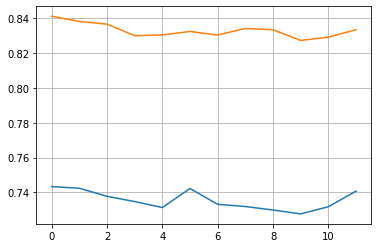

In [64]:
plt.plot(range(len(data_list)),accuracy_mnl.values.T[1])
plt.plot(range(len(data_list)),acc)
plt.grid()